In [330]:
#load packages
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import rasterio
from pyproj import CRS
from shapely.geometry import Point
import networkx as nx
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import nearest_points
import folium
from folium.plugins import MiniMap
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from shapely.geometry import Point
from pyproj import CRS
import math
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

In [365]:
# Load the shapefiles
patients =  gpd.read_file(os.path.abspath('datasets/patient.shp'))
facilities = gpd.read_file(os.path.abspath('datasets/health_facilities.shp'))
roads = gpd.read_file(os.path.abspath('datasets/road.shp'))
viral_suppressions = gpd.read_file(os.path.abspath('datasets/patient.shp'))



In [332]:
# Define projection
#myCRS = ccrs.UTM(29)
crs_utm = ccrs.UTM(34)
#crs_utm = CRS.from_epsg(4326)
patients = patients.to_crs(crs_utm)
facilities = facilities.to_crs(crs_utm)
roads = roads.to_crs(crs_utm)
viral_suppressions = viral_suppressions.to_crs(crs_utm)
districts = districts.to_crs(crs_utm)


In [333]:
viral_suppressions.loc[1]

FID_                                                    861
Name                          Chalabesa Rural Health Centre
viral_supp                                     unsuppressed
Latitude                                         -11.481887
Longitude                                         31.084718
geometry      POINT (1713532.4636682386 -1271899.772047259)
Name: 1, dtype: object

In [334]:
# Create a 5km buffer around each health facility
facilities_buffered = facilities.copy()
facilities_buffered['geometry'] = facilities_buffered.buffer(5000)

In [335]:
# Question 1: Count the number of patients within the 5km radius of each health facility
for index, facility in facilities_buffered.iterrows():
    patients_within_buffer = patients[patients.within(facility.geometry)]
    print("Health facility {} has {} patients within 5km radius.".format(index+1, len(patients_within_buffer)))

Health facility 1 has 2 patients within 5km radius.
Health facility 2 has 2 patients within 5km radius.
Health facility 3 has 4 patients within 5km radius.


In [336]:
# Question 2: Count the number of patients outside the 5km radius of each health facility
for index, facility in facilities_buffered.iterrows():
    patients_outside_buffer = patients[~patients.within(facility.geometry)]
    print("Health facility {} has {} patients outside 5km radius.".format(index+1, len(patients_outside_buffer)))

Health facility 1 has 30 patients outside 5km radius.
Health facility 2 has 30 patients outside 5km radius.
Health facility 3 has 28 patients outside 5km radius.


In [337]:
# Question 3: Calculate the distances patients outside 5km travel to access HIV services at the nearest health facility
patients_outside_buffered = patients[~patients.within(facilities_buffered.geometry.unary_union)]
patients_outside_buffered_nearest = gpd.GeoDataFrame(geometry=list(patients_outside_buffered.geometry))
patients_outside_buffered_nearest['nearest_facility'] = [nearest_points(patient, facilities.geometry.unary_union)[1] for patient in patients_outside_buffered.geometry]
patients_outside_buffered_nearest['distance_to_facility'] = patients_outside_buffered_nearest.apply(lambda row: row['geometry'].distance(row['nearest_facility']), axis=1)
print("Patients outside 5km radius travel an average distance of {} meters to access HIV services at the nearest health facility.".format(patients_outside_buffered_nearest.distance_to_facility.mean()))

Patients outside 5km radius travel an average distance of 11914.364115564225 meters to access HIV services at the nearest health facility.


In [338]:
# Question 4: Count the number of patients with suppressed and unsuppressed viral suppression status within and outside the radius of each health facility
# perform a spatial join between health facilities and patients
patients_within_radius = gpd.sjoin(patients, facilities, how='inner', predicate='within')


In [339]:
print(patients.columns)
print(viral_suppressions.columns)


Index(['FID_', 'Name', 'viral_supp', 'Latitude', 'Longitude', 'geometry'], dtype='object')
Index(['FID_', 'Name', 'viral_supp', 'Latitude', 'Longitude', 'geometry'], dtype='object')


In [340]:
# Question 4: Count the number of patients with suppressed and unsuppressed viral suppression status within and outside the radius of each health facility
for index, facility in facilities_buffered.iterrows():
    patients_within_buffer = patients[patients.within(facility.geometry)]
    patients_within_buffer_viral = patients_within_buffer.merge(viral_suppressions, on='FID_')
    patients_within_buffer_viral_suppressed = patients_within_buffer_viral[patients_within_buffer_viral['viral_supp_x'] == 'suppressed']
    patients_within_buffer_viral_unsuppressed = patients_within_buffer_viral[patients_within_buffer_viral['viral_supp_x'] == 'unsuppressed']
    print("Health facility {} has {} patients within 5km radius with suppressed viral suppression status.".format(index+1, len(patients_within_buffer_viral_suppressed)))
    print("Health facility {} has {} patients within 5km radius with unsuppressed viral suppression status.".format(index+1, len(patients_within_buffer_viral_unsuppressed)))
    
    patients_outside_buffer = patients[~patients.within(facility.geometry)]
    patients_outside_buffer_viral = patients_outside_buffer.merge(viral_suppressions, on='FID_')
    patients_outside_buffer_viral_suppressed = patients_outside_buffer_viral[patients_outside_buffer_viral['viral_supp_y'] == 'suppressed']
    patients_outside_buffer_viral_unsuppressed = patients_outside_buffer_viral[patients_outside_buffer_viral['viral_supp_y'] == 'unsuppressed']
  
    print("Health facility {} has {} patients outside 5km radius with suppressed viral suppression status.".format(index+1, len(patients_outside_buffer_viral_suppressed )))
    print("Health facility {} has {} patients outside 5km radius with unsuppressed viral suppression status.".format(index+1, len(patients_outside_buffer_viral_unsuppressed )))
    print()

Health facility 1 has 2 patients within 5km radius with suppressed viral suppression status.
Health facility 1 has 0 patients within 5km radius with unsuppressed viral suppression status.
Health facility 1 has 21 patients outside 5km radius with suppressed viral suppression status.
Health facility 1 has 9 patients outside 5km radius with unsuppressed viral suppression status.

Health facility 2 has 2 patients within 5km radius with suppressed viral suppression status.
Health facility 2 has 0 patients within 5km radius with unsuppressed viral suppression status.
Health facility 2 has 21 patients outside 5km radius with suppressed viral suppression status.
Health facility 2 has 9 patients outside 5km radius with unsuppressed viral suppression status.

Health facility 3 has 2 patients within 5km radius with suppressed viral suppression status.
Health facility 3 has 2 patients within 5km radius with unsuppressed viral suppression status.
Health facility 3 has 21 patients outside 5km radius

In [378]:
gdf = gpd.read_file(os.path.abspath('datasets/district.shp'))

In [379]:
gdf

,FID_1,Shape_Leng,Shape_Area,FEATURE_TY,PROVINCE,Area_km,PROV_CODE,DIST_CODE,DISTRICT,Shape__Are,Shape__Len,geometry
0,74,8.896313,1.422161,District Town,Muchinga,17235.395194,106,106005,Mpika,1.801886e+10,1.001614e+06,"POLYGON ((31.99622 -11.18335, 31.99669 -11.183..."


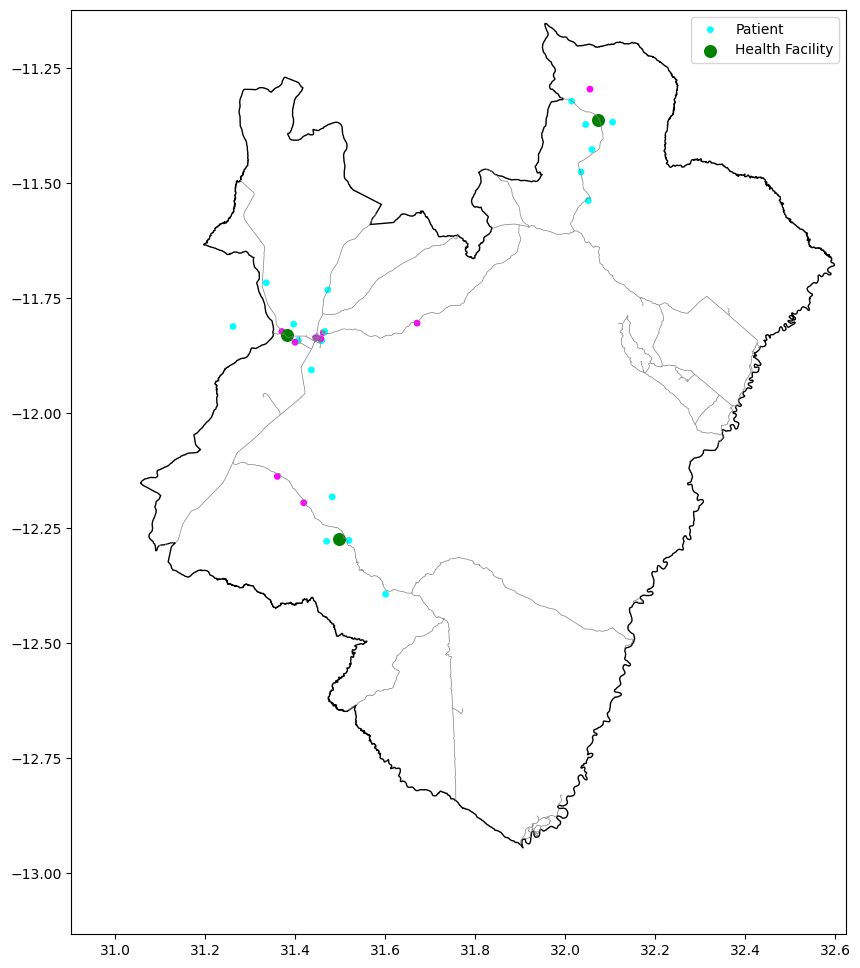

In [382]:
# Create a new figure and axis
fig, ax = plt.subplots(figsize=(10, 60))

# Set the x and y limits of the axis to the bounding box
xmin, ymin, xmax, ymax = roads.total_bounds
buffer_size = 0.19
ax.set_xlim(xmin-buffer_size, xmax+buffer_size)
ax.set_ylim(ymin-buffer_size, ymax+buffer_size)

# Plot patients
patients.plot(ax=ax, markersize=15, legend=True,  column='viral_supp',cmap='cool', label='Patient')

# Plot roads
roads.plot(ax=ax, linewidth=0.5, color='grey', legend=True)

# Plot health facilities and buffer
facilities.plot(ax=ax, marker='o', markersize=70, color='green',legend=True, label='Health Facility')
#facilities_buffer.plot(ax=ax, alpha=0.3, color='blue', label='5km Buffer')
# Plot legend
ax.legend()

# Plot the shapefile with no fill color
gdf.plot(ax=ax, edgecolor='black', facecolor='none')

# Show the plot
plt.show()



In [383]:
#!pip install folium --upgrade